In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

import numpy as np
from itertools import product
from data import make_dataset
from blink import Client
from blink import Server

graph = make_dataset("cora", root="../data")
linkless_graph = graph.clone()
linkless_graph.edge_index = None

In [2]:
import json

with open("config.json") as f:
    conf = json.load(f)

non_private_hparam_space = conf["non_private_hparam_space"]
hparam_space = conf["hparam_space"]

## Baselines

In [3]:
baseline_hparams = [dict(zip(non_private_hparam_space.keys(), values)) for values in product(*non_private_hparam_space.values())]

### MLP

First, let's train a MLP without any link information. This should be the lower bound of our LDP GNN performance.

In [4]:
import math

mlp_min_val_loss = math.inf
mlp_best_hp = None

for hp in baseline_hparams:
    mlp_server = Server(None, None, graph)
    log = mlp_server.fit("mlp", hparam=hp)
    val_loss = log[:,1].min()

    if val_loss < mlp_min_val_loss:
        mlp_min_val_loss = val_loss
        mlp_best_hp = hp

print("Best hparam is: ", mlp_best_hp, "with validation loss", mlp_min_val_loss)

Best hparam is:  {'do': 0.1, 'lr': 0.1, 'wd': 0.001} with validation loss 0.9117609858512878


In [5]:
mlp_res = np.zeros(30)
for i in range(30):
    mlp_server = Server(None, None, graph)
    log = mlp_server.fit("mlp", hparam=mlp_best_hp)
    mlp_res[i] = log[np.argmin(log[:,1]),2]
print("At best hparam, test accuracy is", mlp_res.mean(), "(", mlp_res.std(), ")")

At best hparam, test accuracy is 0.7466461853558628 ( 0.008366057661239157 )


### GCN

Then, let's train a GCN with all the information. This is the non-private upper bound of our LDP GNN.

In [6]:
import math

gcn_min_val_loss = math.inf
gcn_best_hp = None

for hp in baseline_hparams:
    gcn_server = Server(None, None, graph)
    log = mlp_server.fit("gcn", hparam=hp)
    val_loss = log[:,1].min()

    if val_loss < gcn_min_val_loss:
        gcn_min_val_loss = val_loss
        gcn_best_hp = hp

print("Best hparam is: ", gcn_best_hp, "with validation loss", gcn_min_val_loss)

Best hparam is:  {'do': 0.1, 'lr': 0.1, 'wd': 0.0001} with validation loss 0.45350518822669983


In [7]:
gcn_res = np.zeros(30)
for i in range(30):
    gcn_server = Server(None, None, graph)
    log = mlp_server.fit("gcn", hparam=gcn_best_hp)
    gcn_res[i] = log[np.argmin(log[:,1]),2]
print("At best hparam, test accuracy is", gcn_res.mean(), "(", gcn_res.std(), ")")

At best hparam, test accuracy is 0.8539170506912442 ( 0.005833803969881133 )


## Grid Search for hyper parameter tuning

In [8]:
hparam_list = [dict(zip(hparam_space.keys(), values)) for values in product(*hparam_space.values())]

In [9]:
import math

best_hparam = {}
min_val_loss = {}

for eps in [2, 4, 6, 8]:
    min_val_loss[eps] = math.inf
    best_hparam[eps] = None

    for hp in hparam_list:
        client = Client(eps=eps, delta=hp["delta"], data=graph)
        server = Server(eps=eps, delta=hp["delta"], data=linkless_graph)

        priv_adj, priv_deg = client.AddLDP()
        server.receive(priv_adj, priv_deg)
        server.estimate()
        log = server.fit("gcn", hparam=hp)

        val_loss = log[:,1].min()
        if val_loss < min_val_loss[eps]:
            min_val_loss[eps] = val_loss
            best_hparam[eps] = hp
    
    print("Best hparam found at", eps, "", best_hparam[eps], "with validation loss", min_val_loss[eps])

Best hparam found at 2  {'do': 0.1, 'lr': 0.1, 'wd': 0.001, 'delta': 0.9} with validation loss 0.8874484896659851
Best hparam found at 4  {'do': 0.1, 'lr': 0.1, 'wd': 0.0001, 'delta': 0.1} with validation loss 0.7743871808052063
Best hparam found at 6  {'do': 0.1, 'lr': 0.1, 'wd': 0.0001, 'delta': 0.1} with validation loss 0.4369983375072479
Best hparam found at 8  {'do': 0.1, 'lr': 0.1, 'wd': 0.0001, 'delta': 0.1} with validation loss 0.45001134276390076


## Training with best hparam

In [10]:
res = {}
num_trials = 30

for eps in [2, 4, 6, 8]:
    hp = best_hparam[eps]
    res[eps] = np.zeros(num_trials)
    for i in range(num_trials):
        client = Client(eps=eps, delta=hp["delta"], data=graph)
        server = Server(eps=eps, delta=hp["delta"], data=linkless_graph)

        priv_adj, priv_deg = client.AddLDP()
        server.receive(priv_adj, priv_deg)
        server.estimate()
        log = server.fit("gcn", hparam=hp)
        res[eps][i] = log[np.argmin(log[:,1])][2]

In [11]:
{i:(res[i].mean(), res[i].std()) for i in [2, 4, 6, 8]}

{2: (0.7450076804915514, 0.006777426362631566),
 4: (0.76415770609319, 0.014287824659174747),
 6: (0.8508960573476703, 0.0053790254937711715),
 8: (0.8551459293394778, 0.005278906383237968)}

In [1]:
final_res = {
    "0": (0.7466461853558628, 0.008366057661239157),
    "2": (0.7450076804915514, 0.006777426362631566),
    "4": (0.76415770609319, 0.014287824659174747),
    "6": (0.8508960573476703, 0.0053790254937711715),
    "8": (0.8551459293394778, 0.005278906383237968),
    "inf": (0.8539170506912442, 0.005833803969881133)}

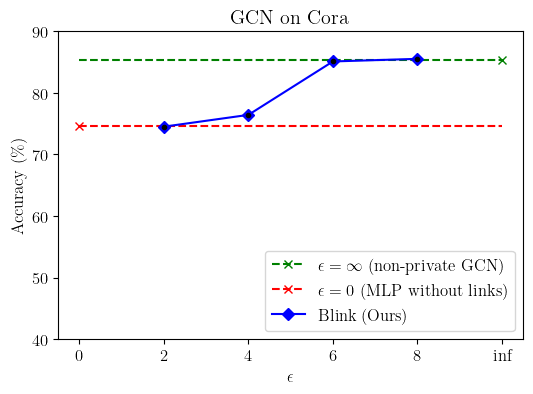

In [36]:
from matplotlib import pyplot as plt

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif', 'serif': 'Linux Libertine O'})
rc('text', usetex=True)
rc('font', **{"size": 12})
rc("figure", figsize=(6,4))

fig = plt.figure()
x = ["0", "2", "4", "6", "8", "inf"]
# plt.yscale("logit")
plt.plot(x, 6*[None], label="_nolegend_")
plt.plot(x, [final_res["inf"][0]*100 for i in x], linestyle='dashed', marker="x", markevery=[5], color="green")
plt.plot(x, [final_res["0"][0]*100 for i in x], linestyle='dashed', marker="x", markevery=[0], color="red")
plt.errorbar(["2","4","6","8"], [final_res[i][0]*100 for i in ["2","4","6","8"]], yerr=[final_res[i][1] for i in ["2","4","6","8"]], fmt='.k', capsize=3)
plt.plot(["2","4","6","8"], [final_res[i][0]*100 for i in ["2","4","6","8"]], marker="D", color="blue")

# plt.yscale("log")
plt.ylim(ymin=40, ymax=90)
plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy (\%)")
plt.title("GCN on Cora")
plt.legend(["$\epsilon=\infty$ (non-private GCN)","$\epsilon=0$ (MLP without links)", "Blink (Ours)"], loc=4)
plt.savefig("log/cora.pdf", bbox_inches='tight')